In [1]:
# 00 - import necessary ppackages
import pandas as pd
import requests
import folium
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

#### 01 - Get data from wikipedia (Provicnes and Cities)

In [2]:
prov_list = ['Shanghai', 'Jiangsu','Zhejiang', 'Anhui','Fujian','Jiangxi','Shandong']

In [3]:
path = r'C:\Users\admin\Desktop\IBM Assignment\Capstone - 02\cn.csv'
city_df = pd.read_csv(path)

In [4]:
#filter out those cities which are not in the east
city_df['cond'] = city_df['admin'].apply(lambda x : 1 if x in prov_list else 0)

city_df = city_df.where(city_df['cond']==1).dropna(axis = 0, how = 'all')
city_df.reset_index(drop=True, inplace = True)

#### 02 - Get Foursquare data and construct dataset

In [5]:
CLIENT_ID = 'AOHS3WCWE1ZVPB4F3LQNMIE5DY2ULFSDMA0G1MN20LL35LCW'
CLIENT_SECRET = '4FB5FLLAXMEVXFRYT4R251SM2XSSCOU55SYKK4E0XPAMRZWJ'
VERSION = '20200101'

In [6]:
RADIUS = 5000  #Check the top picks within 5km range in every cities
LIMIT = 500   #Set the number of top picks to 500

In [8]:
#define a function to retrieve top 500 recommendated venues around each area
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        results
        try:
            r_venues = results['groups'][0]['items']
        except:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in r_venues])
    
    return(venues_list)

In [9]:
#use the defined function to get venues
city_venue = getNearbyVenues(city_df['city'], city_df['lat'],city_df['lng'])

Shanghai
Nanjing
Zhangzhou
Zibo
Hangzhou
Qingdao
Jinan
Fuzhou
Xiamen
Wenzhou
Nanchangshi
Daguozhuangcun
Yantai
Linyi
Hefei
Suzhou
Ningbo
Shucheng
Wuxi
Lu’an
Suzhou
Tai’an
Weifang
Tantou
Quanzhou
Huainan
Huashan
Heze
Zhangshu
Huaiyin
Huzhou
Jining
Shangrao
Jinhua
Jiaxing
Yichun
Xigui
Pingxiang
Nantong
Xinyu
Huaibei
Xiaobengbu
Xuanzhou
Rizhao
Zhenjiang
Yuanzhuang
Wuhubei
Shaoxing
Fuyuan
Hanzhuang
Taizhou
Anqing
Tongling
Weihai
Sunjialong
Yangzhou
Jiangxia
Jiaojiang
Jingdezhen
Dezhou
Putian
Quzhou
Longyan
Ningde
Linhai
Laiyang
Xiahuang
Qiantucheng
Nanping
Sanming
Huangyan
Lishui
Fuyang
Jieshou
Laiwu
Binzhou
Shaowu
Yishui
Pingdu
Guangming
Pingyi
Shangchengjia
Dunhou
Chengwu
Yongning
Wenhua
Suicheng
Baoshan
Liaocheng
Qingkou
Guancheng
Pudong
Hecheng
Haimen
Songling
Changzhou
Luxi
Weitang
Fuding
Dangcheng
Gushu
Xibu
Helixi
Suixi
Lubei
Shouchun
Luofeng
Huangshan
Hongkou
Fuyu
Dongcheng
Yicheng
Jiading
Sicheng
Nanchansi
Fengchuan
Chong’ansi
Jianping
Jingcheng
Xinpu
Hangchuan
Pucheng
Poyang
Gant

In [10]:
#convert the list to a dataframe
venue_df = pd.DataFrame(columns = ['Name','lon','lat','venue','v_lon','v_lat','cat'])

for i in range(len(city_venue)):
    mini_df =  pd.DataFrame(city_venue[i], columns = ['Name','lon','lat','venue','v_lon','v_lat','cat'])
    venue_df = pd.concat([venue_df,mini_df],axis=0)

venue_df.reset_index(drop = True, inplace = True)

In [62]:
len(venue_df.Name.unique())


394

#### 03 - Feature engineering 

In [11]:
#Feauture engineering based on the catagory
city_onehot = pd.get_dummies(venue_df['cat'])
city_onehot['Name'] = venue_df['Name']

In [83]:
# group the data by area name and calculate the mean as appreance frequency of venues
city_grouped = city_onehot.groupby('Name').mean()
city_grouped = city_grouped.reset_index()

In [13]:
#Define a function to check what the top 10 most common venues for each city are

def return_most_common_venues(row, num_top):
    row_cat = row.iloc[1:]
    row_cat_sorted = row_cat.sort_values(ascending = False)
    
    return row_cat_sorted.index.values[0:num_top]

In [14]:
#Create a dataframe to store top 10 venues
common_str =  ' Most Common Venue'    
seq_list = ['st','nd', 'rd']
columns = ['city']
for ind in range(10):
    try: 
        columns.append(str(ind+1) + seq_list[ind] + common_str)
    except:
        columns.append(str(ind+1) + 'th' + common_str)
        
top10_df = pd.DataFrame(columns = columns)
top10_df['city'] = city_grouped['Name']

for ind in range(city_grouped.shape[0]):
    top10_df.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :],10)

In [67]:
top10_df
#top10_df[top10_df['city']=='Shanghai']

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Andongwei,Hotel,Harbor / Marina,Chinese Restaurant,Boat or Ferry,Shandong Restaurant,Zoo,Football Stadium,Food Service,Food Truck,French Restaurant
1,Anqing,Fast Food Restaurant,Hotel,Train Station,Shopping Plaza,Food Truck,Food & Drink Shop,Food Court,Food Service,Football Stadium,Flea Market
2,Aoyang,Bus Station,Zoo,German Restaurant,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Fountain
3,Baiguan,Train Station,Hotel,Fast Food Restaurant,Coffee Shop,Fountain,Food Court,Food Service,Food Truck,Football Stadium,Zoo
4,Baoshan,Coffee Shop,Port,Stadium,Shopping Mall,Park,Fast Food Restaurant,Football Stadium,Fountain,Food,Food Truck
5,Bashan,Market,Plaza,Zoo,Food,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant
6,Beidajie,Coffee Shop,Fast Food Restaurant,Hotel,Shopping Mall,Mexican Restaurant,Garden,Burger Joint,General Entertainment,Grocery Store,Chinese Restaurant
7,Beijinglu,Hotel,Bus Station,Park,Lake,Sculpture Garden,Shopping Mall,Food & Drink Shop,Food Court,Food Service,Food Truck
8,Beilun,Coffee Shop,Pier,Pizza Place,Movie Theater,Hotel,Shopping Mall,Fast Food Restaurant,Fountain,Football Stadium,Food
9,Binhu,Coffee Shop,Hotel,Fast Food Restaurant,Shopping Mall,Hotpot Restaurant,Indian Restaurant,Chinese Restaurant,Historic Site,Clothing Store,Burger Joint


#### 04 Use the elbow method to determine the optimal number of clusters, namely the K

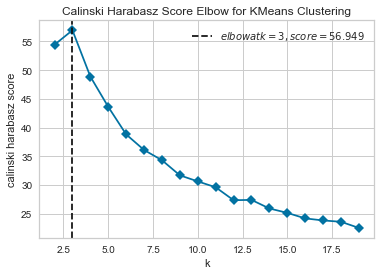

In [15]:
X = city_grouped.drop(['Name'],axis = 1)
model = KMeans()
visualizer = KElbowVisualizer(
        model,
        k = (2,20),
        metric = 'calinski_harabasz',
        timings = False
        )

visualizer.fit(X)
visualizer.show()

In [16]:
# As shown above, K should be 3
num_cluster = 3

#### 05 Run clusters

In [17]:
data = city_grouped.drop('Name', axis = 1)
kmeans = KMeans(n_clusters = num_cluster, random_state=0)
clusters =kmeans.fit(data)
labels = clusters.labels_

In [85]:
# Update the dataset after clustering

#Add cluster label
city_grouped['Label'] = labels

(394, 245)

In [86]:
#add the longitude and latitude into trt_grouped
gps_list = ['city','lat','lng']
gps_df = city_df[gps_list].copy()

city_grouped = city_grouped.merge(gps_df, how='left', left_on='Name', right_on='city')
city_grouped.drop(['city'],axis = 1,inplace = True)

#### 06 Visualization on the folium map

In [91]:
color_list = ['red', 'green','blue']  #change accordingly with the number of clusters

city_clustermap = folium.Map(location = [31.33,121.66], zoom_start = 5)

for lat, lon, name, cluster in zip(city_grouped['lat'], city_grouped['lng'],city_grouped['Name'], city_grouped['Label']):
    label = name + ", belongs to cluster " + str(cluster)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
            [lat, lon],
            radius = 2,
            popup = label,
            color = color_list[int(cluster)],
            fill = True,
            fill_color = color_list[cluster]).add_to(city_clustermap)

city_clustermap

#### 07 Analysis

In [105]:
#Ranking of three clusters
label_df = city_grouped[['Name', 'Label']].copy()
analysis_df = top10_df.merge(label_df, how= 'left', left_on='city',right_on = 'Name')

analysis_df

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Name,Label
0,Andongwei,Hotel,Harbor / Marina,Chinese Restaurant,Boat or Ferry,Shandong Restaurant,Zoo,Football Stadium,Food Service,Food Truck,French Restaurant,Andongwei,0
1,Anqing,Fast Food Restaurant,Hotel,Train Station,Shopping Plaza,Food Truck,Food & Drink Shop,Food Court,Food Service,Football Stadium,Flea Market,Anqing,0
2,Aoyang,Bus Station,Zoo,German Restaurant,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Aoyang,0
3,Aoyang,Bus Station,Zoo,German Restaurant,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Aoyang,0
4,Baiguan,Train Station,Hotel,Fast Food Restaurant,Coffee Shop,Fountain,Food Court,Food Service,Food Truck,Football Stadium,Zoo,Baiguan,0
5,Baoshan,Coffee Shop,Port,Stadium,Shopping Mall,Park,Fast Food Restaurant,Football Stadium,Fountain,Food,Food Truck,Baoshan,0
6,Bashan,Market,Plaza,Zoo,Food,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Bashan,0
7,Beidajie,Coffee Shop,Fast Food Restaurant,Hotel,Shopping Mall,Mexican Restaurant,Garden,Burger Joint,General Entertainment,Grocery Store,Chinese Restaurant,Beidajie,0
8,Beijinglu,Hotel,Bus Station,Park,Lake,Sculpture Garden,Shopping Mall,Food & Drink Shop,Food Court,Food Service,Food Truck,Beijinglu,2
9,Beilun,Coffee Shop,Pier,Pizza Place,Movie Theater,Hotel,Shopping Mall,Fast Food Restaurant,Fountain,Football Stadium,Food,Beilun,0


In [103]:
print(color_list)
ana_df.groupby('Label').count()['city']

#from below we see that 
#Most of the cities in the east China falls into group 0, about 2/3, which suggests uniformity
#Blue dots are scatterd and accounts for roughly 30% of total cities
# There are a few cities fall into green group and as shown in the map, they tend to be away from coastline
#Let's see typical top picks from different clusters


['red', 'green', 'blue']


Label
0    267
1     25
2    133
Name: city, dtype: int64

In [150]:
#Let's aggregate top 10 venues within 3 clusters and find out the final top 10 most common venues for each group

zero_df = analysis_df.where(analysis_df['Label']==0).dropna(how='all',axis = 0)
one_df = analysis_df.where(analysis_df['Label']==1).dropna(how='all',axis = 0)
two_df = analysis_df.where(analysis_df['Label']==2).dropna(how='all',axis = 0)


In [112]:
zero_df

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Name,Label
0,Andongwei,Hotel,Harbor / Marina,Chinese Restaurant,Boat or Ferry,Shandong Restaurant,Zoo,Football Stadium,Food Service,Food Truck,French Restaurant,Andongwei,0.0
1,Anqing,Fast Food Restaurant,Hotel,Train Station,Shopping Plaza,Food Truck,Food & Drink Shop,Food Court,Food Service,Football Stadium,Flea Market,Anqing,0.0
2,Aoyang,Bus Station,Zoo,German Restaurant,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Aoyang,0.0
3,Aoyang,Bus Station,Zoo,German Restaurant,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Aoyang,0.0
4,Baiguan,Train Station,Hotel,Fast Food Restaurant,Coffee Shop,Fountain,Food Court,Food Service,Food Truck,Football Stadium,Zoo,Baiguan,0.0
5,Baoshan,Coffee Shop,Port,Stadium,Shopping Mall,Park,Fast Food Restaurant,Football Stadium,Fountain,Food,Food Truck,Baoshan,0.0
6,Bashan,Market,Plaza,Zoo,Food,Gastropub,Garden,Furniture / Home Store,Fujian Restaurant,Fried Chicken Joint,French Restaurant,Bashan,0.0
7,Beidajie,Coffee Shop,Fast Food Restaurant,Hotel,Shopping Mall,Mexican Restaurant,Garden,Burger Joint,General Entertainment,Grocery Store,Chinese Restaurant,Beidajie,0.0
9,Beilun,Coffee Shop,Pier,Pizza Place,Movie Theater,Hotel,Shopping Mall,Fast Food Restaurant,Fountain,Football Stadium,Food,Beilun,0.0
10,Binhu,Coffee Shop,Hotel,Fast Food Restaurant,Shopping Mall,Hotpot Restaurant,Indian Restaurant,Chinese Restaurant,Historic Site,Clothing Store,Burger Joint,Binhu,0.0


In [176]:
#define a function that spits out a list of top 10 most common venues

def top10(df):
    sum_list = []
    for i in range(df.shape[0]):
        sum_list+= list(df.iloc[i,1:11])
    sum_df = pd.Series(sum_list)
    ten_df = sum_df.value_counts()[:10]
    return round(ten_df/ten_df.sum()*100,2)

In [177]:
#check cluster 
top10(zero_df)

Hotel                     15.02
Zoo                       11.58
Fast Food Restaurant      10.95
Coffee Shop                9.68
Fried Chicken Joint        9.32
French Restaurant          9.14
Garden                     8.87
Fujian Restaurant          8.69
Furniture / Home Store     8.42
Shopping Mall              8.33
dtype: float64

In [178]:
top10(one_df)

#Small citiee: people frequently travel to big cities for work

Train Station             12.14
Zoo                       11.65
Fried Chicken Joint       10.19
Furniture / Home Store    10.19
Gastropub                 10.19
Fujian Restaurant         10.19
Garden                    10.19
French Restaurant          9.22
Food & Drink Shop          8.74
General Entertainment      7.28
dtype: float64

In [179]:
top10(two_df)

Hotel                     16.96
Zoo                       11.73
Fried Chicken Joint       10.20
Fujian Restaurant         10.08
Furniture / Home Store     9.44
French Restaurant          9.31
Garden                     9.31
Food                       9.06
Gastropub                  7.53
Food Truck                 6.38
dtype: float64

In [ ]:
#Fujian restaurant and french restaurant -- interesting